# Online Joint State and Parameters Estimation for AR SSM
State space model
\begin{align*}
    &\mathbf{x}_t = A(\theta)\mathbf{x}_{t-1} + \mathbf{c}v_{t} \quad v_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = \mathbf{c}^{\top} \theta_t^{(0)} + w_t \quad w_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

or

Probabilistic model
\begin{align}
  p&(\mathbf{X}, \mathbf{y}, \theta, \gamma) = \underbrace{p(\mathbf{x}_0)p(\gamma_x)p(\gamma_y)p(\theta)}_{\text{priors}}\prod_{t=1}^{T}\underbrace{p(y_t|\mathbf{x}_t, \gamma_y)}_{\text{observation}}\underbrace{p(\mathbf{x}_t|\mathbf{x}_{t-1}, \theta, \gamma_x)}_{\text{state transition}}  \\
    p&(y_t|\mathbf{x}_t, \gamma_y) = \mathcal{N}\Bigl(y_t|\mathbf{x}_{t}, \gamma_y^{-1}\Bigr) \\
  p&(\mathbf{x}_t|\mathbf{x}_{t-1}, \theta, \gamma_x) = \mathcal{N}\Bigl(\mathbf{x}_t|A(\theta)\mathbf{x}_{t-1}, V\Bigr) \\
  p&(\mathbf{x}_0) = \mathcal{N}(\mathbf{x}_0|m_{\mathbf{x}_{0}}, V_{\mathbf{x}_{0}})  \\
  p&(\theta) = \mathcal{N}(\theta|m_{\theta}, V_{\theta}) \\
  p&(\gamma_x) = \Gamma(\gamma_x|\alpha_x, \beta_x) 
\end{align}

where
\begin{align*}
    &\mathbf{x}_t = (x_t, x_{t-1}, \dots, x_{t-p+1})^\top \quad \mathbf{x}_{t-1} = (x_{t-1}, x_{t-2}, \dots, x_{t-p})^\top \quad \mathbf{c} = (1, 0, ..., 0)^{\top} \\ \\
    &A(\theta) = 
    \begin{bmatrix}
         \theta^{\top}  \\
         \mathbf{I}_{M-1} \quad \mathbf{0}
    \end{bmatrix}
    \, , \quad
    \mathbf{I}_M = 
    \begin{bmatrix}
        1_1 & 0 &  \dots & 0 \\ 
        0 & 1_2 &  \dots & 0 \\   
        \vdots &  \vdots & \ddots & \vdots \\
        0 & 0  & \dots & 1_{M}
    \end{bmatrix} \, ,\quad
      V= \begin{bmatrix}
            1/\gamma & 0 &\dots & 0 \\ 
            0 & \epsilon & \dots & 0 \\   
            \vdots & \vdots & \ddots & \vdots \\
             0 & 0 & \dots & \epsilon
    \end{bmatrix}
\end{align*}

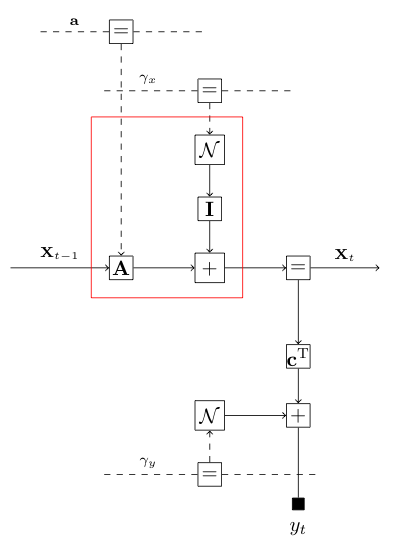

In [1]:
using Images
img = load("../ffgs/AR-online.png")

The central quantity of our interest is a joint estimation of the AR coefficients $\mathbf{a}$, precision of process noise $\gamma_x$ and states $\mathbf{x}_n$, while setting measurement noise precisions $\gamma_y=2.0$.

In [2]:
using Random
using LaTeXStrings
using Plots
include("../data/ARdata.jl")
include("../models/AR.jl")
import Main.ARdata: loadAR, generateAR, writeAR, readAR

In [21]:
Random.seed!(42)

# Define the order and data
ARorder = 5
diagAR(dim) = Matrix{Float64}(I, dim, dim)

# AR data
v_x = 1.0 # process noise variance
coefs, dataAR = generateAR(1000, ARorder, nvar=v_x, stat=true)
x = [x[1] for x in dataAR]
#dataAR = loadAR("../data/temperature.csv", col=:Temp, delim=",")

v_y = 10.0 # measurement noise variance
# Observations

y = [x[1] + sqrt(v_y)*randn() for x in dataAR];

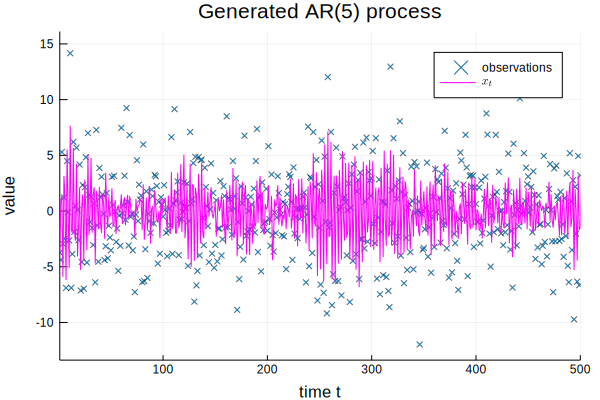

In [22]:
from = 1; upto = 500;
plot(xlims=(from, upto))
scatter!(y, markershape = :xcross, markeralpha = 0.6, markersize = 2, xlabel="time t", ylabel="value", label="observations")
plot!(x, color=:magenta, label=L"x_t", title="Generated AR($ARorder) process")

In [23]:
gar, qar = buildGraphAR(ARorder)
setCurrentGraph(gar)
ForneyLab.draw(gar)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 12575205126515756264 -->
 
 12575205126515756264 
 
 placeholder_w_x_t_prev 
 
<!-- 4415476279983024083 -->
 
 4415476279983024083 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 12575205126515756264--4415476279983024083 -->
 
 12575205126515756264--4415476279983024083 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 2874758322769855184 -->
 
 2874758322769855184 
 
 Gam 
 gamma_1 
 
<!-- 13129979998716667981 -->
 
 13129979998716667981 
 
 observationAR 
 observationar_1 
 
<!-- 16017272106195782068 -->
 
 16017272106195782068 
 
 Autoregression 
 autoregression_1 
 
<!-- 13129979998716667981--16017272106195782068 -->
 
 13129979998716667981--16017272106195782068 
 
 x_t 
 1 out 
 2 x 
 
<!-- 15906817744998247612 -->
 
 15906817744998247612 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 11610932573808688410 -->
 
 11610932573808688410 
 
 placeholder_m_x_t_prev 
 
<!-- 11610932573808688410--4415476279983024083 -->
 
 11610932573808688410--4415476279983024083 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 4574139329794905371 -->
 
 4574139329794905371 
 
 placeholder_w_a_t 
 
<!-- 4574139329794905371--15906817744998247612 -->
 
 4574139329794905371--15906817744998247612 
 
 w_a_t 
 3 w 
 1 out 
 
<!-- 15688762150028792675 -->
 
 15688762150028792675 
 
 placeholder_m_a_t 
 
<!-- 15688762150028792675--15906817744998247612 -->
 
 15688762150028792675--15906817744998247612 
 
 m_a_t 
 2 m 
 1 out 
 
<!-- 16017272106195782068--2874758322769855184 -->
 
 16017272106195782068--2874758322769855184 
 
 w 
 1 out 
 4 W 
 
<!-- 16017272106195782068--15906817744998247612 -->
 
 16017272106195782068--15906817744998247612 
 
 a 
 1 out 
 3 a 
 
<!-- 16017272106195782068--4415476279983024083 -->
 
 16017272106195782068--4415476279983024083 
 
 x_t_prev 
 1 out 
 2 x 
 
<!-- 1914570180862477682 -->
 
 1914570180862477682 
 
 placeholder_b_w_t 
 
<!-- 1914570180862477682--2874758322769855184 -->
 
 1914570180862477682--2874758322769855184 
 
 b_w_t 
 3 b 
 1 out 
 
<!-- 12185862576415111359 -->
 
 12185862576415111359 
 
 placeholder_a_w_t 
 
<!-- 12185862576415111359--2874758322769855184 -->
 
 12185862576415111359--2874758322769855184 
 
 a_w_t 
 2 a 
 1 out 
 
<!-- 9587667550244017799 -->
 
 9587667550244017799 
 
 placeholder_m_y_t 
 
<!-- 9587667550244017799--13129979998716667981 -->
 
 9587667550244017799--13129979998716667981 
 
 m_y_t 
 1 y 
 1 out 
 
<!-- 10527524991978359505 -->
 
 10527524991978359505 
 
 placeholder_w_y_t 
 
<!-- 10527524991978359505--13129979998716667981 -->
 
 10527524991978359505--13129979998716667981 
 
 w_y_t 
 3 z 
 1 out

In [25]:
prs = Dict(:m_a=>zeros(ARorder), :w_a=>10.0*diagAR(ARorder),
           :m_x=>zeros(ARorder), :w_x=>diagAR(ARorder),
           :a=>0.00001, :b=>0.00001)

# If Julia throws an error just ignore and re-run the inference again
result = inferAR(qar, y, v_y, priors=prs, r_stats=true);

Observed 100%|██████████████████████████████████████████| Time: 0:00:06


In [26]:
# Inspect the results
marginals = result[1]
FAR = result[3]
posteriors = result[4]

m_x = posteriors[:m_x]
w_x = posteriors[:w_x]
m_a = posteriors[:m_a]
w_a = posteriors[:w_a]
a = posteriors[:a]
b = posteriors[:b]

m_ar = [x[1] for x in m_x]
v_ar = [v_x[1]^-1 for v_x in w_x[1:end]];

logPDFsAR = [logPDF(x[t], m_x[t][1], w_x[t][1]^-1) for t in 1:length(y)]
WMSEsAR = [wmse(x[1:t], [est[1] for est in m_x[1:t]], [est[1]^-1 for est in w_x[1:t]]) for t in 1:length(y)];

In [27]:
println("Coefs")
println("real = ", coefs)
println("estimated mean = ", unsafeMean(marginals[:a]))
println("===============")
println("Noise")
println("real variance = ", v_x)
println("estimated variance = ", unsafeMean(marginals[:w])^-1)

Coefs
real = [-0.441035, -0.0106585, 0.407541, -0.382486, -0.430636]
estimated mean = [-0.190343, -0.139421, -0.633772, -0.232485, 1.29963]
Noise
real variance = 1.0
estimated variance = 1.8384582959413385


In [28]:
# Doesn't really matter
println("Δ(estimated, real)=", mse(m_ar, x))
println("Δ(estimated, noise)=", mse(m_ar, y))
println("Δ(noise, actual)=", mse(y, x))

Δ(estimated, real)=5.469488690281536
Δ(estimated, noise)=12.075387191940223
Δ(noise, actual)=9.475893141147653


# Random walk model 
As a benchamrk, we use the following RW model.
\begin{align*}
    &x_t = x_{t-1} + p_t \quad p_t \sim \mathcal{N}(0, \gamma_x^{-1}) \\
    &y_t = x_t + m_t \quad m_t \sim \mathcal{N}(0, \gamma_y^{-1})
\end{align*}

We set $\gamma_y = \frac{1}{2}$

In [29]:
# Generate data first!

rwg = FactorGraph()

# declare priors as random variables
@RV a_w
@RV b_w
@RV m_x_t_prev
@RV w_x_t_prev
@RV w_y_t

@RV w ~ Gamma(a_w, b_w)
@RV x_t_prev ~ GaussianMeanPrecision(m_x_t_prev, w_x_t_prev)
@RV x_t ~ GaussianMeanPrecision(x_t_prev, w)
@RV y_t ~ GaussianMeanPrecision(x_t, w_y_t)

# Placeholders for prior
placeholder(a_w, :a_w)
placeholder(b_w, :b_w)
placeholder(m_x_t_prev, :m_x_t_prev)
placeholder(w_x_t_prev, :w_x_t_prev)

# Placeholder for data
placeholder(y_t, :y_t)
placeholder(w_y_t, :w_y_t)
ForneyLab.draw(rwg)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 11861772480914936984 -->
 
 11861772480914936984 
 
 placeholder_m_x_t_prev 
 
<!-- 7141834541046397300 -->
 
 7141834541046397300 
 
 𝒩 
 gaussianmeanprecision_1 
 
<!-- 11861772480914936984--7141834541046397300 -->
 
 11861772480914936984--7141834541046397300 
 
 m_x_t_prev 
 2 m 
 1 out 
 
<!-- 5441851779161294439 -->
 
 5441851779161294439 
 
 placeholder_w_y_t 
 
<!-- 17233952797985759169 -->
 
 17233952797985759169 
 
 𝒩 
 gaussianmeanprecision_3 
 
<!-- 5441851779161294439--17233952797985759169 -->
 
 5441851779161294439--17233952797985759169 
 
 w_y_t 
 3 w 
 1 out 
 
<!-- 11072241875317985362 -->
 
 11072241875317985362 
 
 placeholder_b_w 
 
<!-- 14723915117374765140 -->
 
 14723915117374765140 
 
 Gam 
 gamma_1 
 
<!-- 11072241875317985362--14723915117374765140 -->
 
 11072241875317985362--14723915117374765140 
 
 b_w 
 3 b 
 1 out 
 
<!-- 5937528616232398309 -->
 
 5937528616232398309 
 
 𝒩 
 gaussianmeanprecision_2 
 
<!-- 5937528616232398309--14723915117374765140 -->
 
 5937528616232398309--14723915117374765140 
 
 w 
 1 out 
 3 w 
 
<!-- 5937528616232398309--7141834541046397300 -->
 
 5937528616232398309--7141834541046397300 
 
 x_t_prev 
 1 out 
 2 m 
 
<!-- 17233952797985759169--5937528616232398309 -->
 
 17233952797985759169--5937528616232398309 
 
 x_t 
 1 out 
 2 m 
 
<!-- 3755576248495120261 -->
 
 3755576248495120261 
 
 placeholder_w_x_t_prev 
 
<!-- 3755576248495120261--7141834541046397300 -->
 
 3755576248495120261--7141834541046397300 
 
 w_x_t_prev 
 3 w 
 1 out 
 
<!-- 4324102920862447951 -->
 
 4324102920862447951 
 
 placeholder_a_w 
 
<!-- 4324102920862447951--14723915117374765140 -->
 
 4324102920862447951--14723915117374765140 
 
 a_w 
 2 a 
 1 out 
 
<!-- 6532574283007651248 -->
 
 6532574283007651248 
 
 placeholder_y_t 
 
<!-- 6532574283007651248--17233952797985759169 -->
 
 6532574283007651248--17233952797985759169 
 
 y_t 
 1 out 
 1 out

In [30]:
# Specify recognition factorization
q = RecognitionFactorization(x_t, w, ids=[:X_t :W])

# Generate the variational update algorithms for each recognition factor
algo = variationalAlgorithm(q)
algoF = freeEnergyAlgorithm()

eval(Meta.parse(algo))
eval(Meta.parse(algoF))

freeEnergy (generic function with 1 method)

In [31]:
# Define values for prior statistics
m_x_prev_0 = 0.0
w_x_prev_0 = 1.0
# FIXME
a_w_0 = 0.00001
b_w_0 = 0.00001

n_samples = length(y)
a_w = Vector{Float64}(undef, n_samples)
b_w = Vector{Float64}(undef, n_samples)
m_x = Vector{Float64}(undef, n_samples)
w_x = Vector{Float64}(undef, n_samples)

m_x_t_prev_min = m_x_prev_0
w_x_t_prev_min = w_x_prev_0
a_w_t_min = a_w_0
b_w_t_min = b_w_0;

In [32]:
data = Dict()
marginals = Dict()
n_its = 5

# Storage for score
WMSEsRW = []
logPDFsRW = []
FRW = []

p = Progress(length(y), 1, "Observed ")
for t = 1:length(y)
    update!(p, t)
    marginals[:x_t_prev] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=m_x_t_prev_min, w=w_x_t_prev_min)
    marginals[:w] = ProbabilityDistribution(Univariate, Gamma, a=a_w_t_min, b=b_w_t_min)
    global m_x_t_prev_min, w_x_t_prev_min, a_w_t_min, b_w_t_min, data
    
    for i = 1:n_its
        data = Dict(:y_t => y[t],
                    :w_y_t => v_y^-1,
                    :m_x_t_prev => m_x_t_prev_min,
                    :w_x_t_prev => w_x_t_prev_min,
                    :a_w => a_w_t_min,
                    :b_w => b_w_t_min)
        
        stepX_t!(data, marginals)
        stepW!(data, marginals)
        m_x[t] = mean(marginals[:x_t])
        w_x[t] = var(marginals[:x_t])^-1
        a_w[t] = marginals[:w].params[:a]
        b_w[t] = marginals[:w].params[:b]
        
        m_x_t_prev_min = m_x[t]
        w_x_t_prev_min = w_x[t]
        a_w_t_min = a_w[t]
        b_w_t_min = b_w[t]
    end
    push!(FRW, (freeEnergy(data, marginals)))
    push!(logPDFsRW, logPDF(x[t], m_x[t][1], w_x[t][1]^-1))
    push!(WMSEsRW, wmse(x[1:t], m_x[1:t], w_x[1]^-1))
end

In [33]:
println("Process noise variance\n=========")
println("Estimated ", mean(marginals[:w])^-1)
println("True ", 1.0)

println("\nState\n=========")
println("Mean ", mean(marginals[:x_t]))
println("Var ", var(marginals[:x_t]))

Process noise variance
Estimated 35.01806741299101
True 1.0

State
Mean 1.2252030927815794
Var 7.778835311920985


In [34]:
# Extracting estimates for x_t (first component of vector x̄_t) for plotting
m_rw = [m_x[1] for m_x in m_x[1:end]];
v_rw = [v_x[1]^-1 for v_x in w_x[1:end]];

# Comparison
To assess the performance of our model, we use the following metric:
$$\sum_{i=1}^Te^{i-T}\frac{(m_{x_{k}}-x_{k})^2}{v_x}$$
where
$m_{x_{k}}$ - estimated mean of the hidden state,
$v_{x_{k}}$ - estimated variance of the hidden state,
$T$ - number of available observations

and Free Energy:
$$F_t[q]\triangleq \int q(\mathbf{x}_t)\log\frac{q(\mathbf{x}_t)}{p(\mathbf{x}_t, y_t\big|\mathbf{y}_{1:t-1})}d\mathbf{x}_t$$

We also track log PDF, i.e.:
$$-\frac{1}{2}\log{2\pi v_x}-\frac{(m_{x_{k}}-x_{k})^2}{2v_x}$$

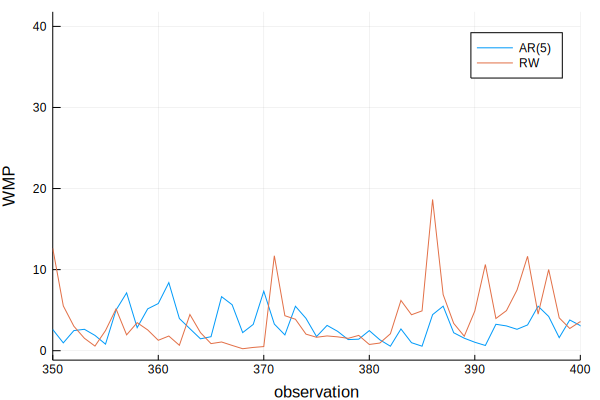

In [35]:
# Plotting
from, upto = 350, 400
plot(WMSEsAR, label="AR($ARorder)", xlims=(from, upto))
plot!(WMSEsRW, xlabel="observation", ylabel="WMP", label="RW")

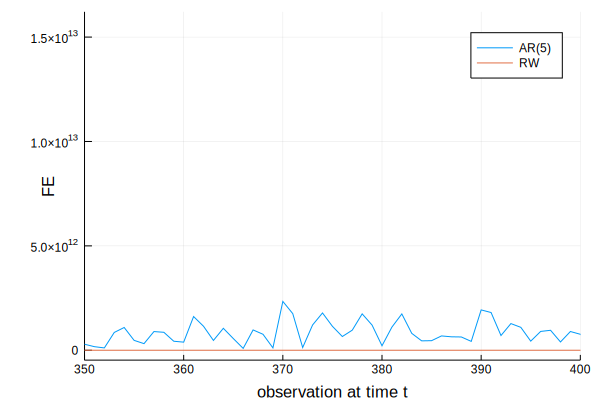

In [36]:
# Free energy
plot(FAR[2:end], label="AR($ARorder)", xlims=(from, upto))
plot!(FRW[2:end], label="RW", xlabel="observation at time t", ylabel="FE")

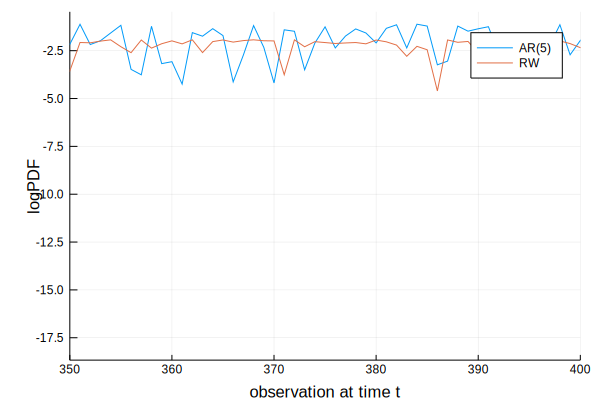

In [37]:
# log PDFs
plot(logPDFsAR[1:end], label="AR($ARorder)", xlims=(from, upto))
plot!(logPDFsRW[1:end], label="RW", xlabel="observation at time t", ylabel="logPDF", size=(600, 400))

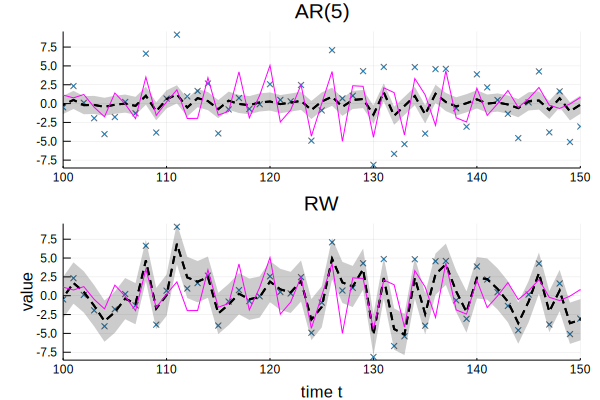

In [38]:
from = 100
upto = 150 # limit for building a graph 
scale = 1.0 # scale for the variance

scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_rw, m_rw], fillrange=[m_rw - scale .* sqrt.(v_rw), m_rw + scale .* sqrt.(v_rw)],
      linestyle=:dash,linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pRW = plot!(xlabel="time t", ylabel="value", title="RW")


scatter(y, label="noisy observations", 
        markershape = :xcross, markeralpha = 0.6,
        markersize = 2)
plot!([m_ar, m_ar], fillrange=[m_ar - scale .* sqrt.(v_ar), m_ar + scale .* sqrt.(v_ar)],
      linestyle=:dash, linewidth = 2,
      color=:black,
      fillalpha = 0.2,
      fillcolor = :black,
      label=["inferred", "inferred"])
plot!(x, color = :magenta, linewidth = 1.0, label="real state")
pAR = plot!(title="AR($ARorder)", legend=false)

plot(pAR, pRW, xlims=(from, upto), 
    ylims=(minimum(y[from:upto]) - 0.42, maximum(y[from:upto]) + 0.42), 
    layout=(2,1), legend=false)

# Animation

In [44]:
v_x = v_ar # variances of estimated state
toshow = 10 # number of points to plot at once

anim = @animate for i in 1:length(m_rw)-toshow
    s = plot(xticks = i:div(toshow, 2):i+toshow);
    ylims!(minimum(y) - .1, maximum(y) + .1);
    scatter!(collect(i:i+toshow), y[i:i+toshow], label="noisy observations", 
            markershape = :xcross, markeralpha = 0.6,
            markersize = 2)
    
    plot!(collect(i:i+toshow), m_ar[i:i+toshow], ribbon=(sqrt.(v_x[i:i+toshow]), sqrt.(v_x[i:i+toshow])),
          linestyle=:dash, linewidth = 2, color=:black, fillalpha = 0.2, fillcolor = :black,
          label="inferred")
    
    plot!(collect(i:i+toshow), x[i:i+toshow], color = :magenta, linewidth = 1.0, label="real state")
end

Animation("/var/folders/jn/1xv7kskx42v_97gx1xd8y_g40000gq/T/tmpLwxMMG", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000981.png", "000982.png", "000983.png", "000984.png", "000985.png", "000986.png", "000987.png", "000988.png", "000989.png", "000990.png"])

In [22]:
gif(anim, "../gifs/AR-LDS.gif", fps = 10)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-LDS.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/AR-LDS.gif")

In [23]:
# Plotting MSE
anim = @animate for i in 1:length(WMSEs)
    s = plot()
    ylims!(minimum(WMSEs) - 1, maximum(WMSEs) + 1)
    xlims!(1, length(WMSEs))
    plot!(collect(1:i), WMSEs[1:i], xlabel="observation", ylabel="WMSE", label="")
end;

In [24]:
gif(anim, "../gifs/MSE_evo_state.gif", fps = 100)

┌ Info: Saved animation to 
│   fn = /Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif
└ @ Plots /Users/albertpod/.julia/packages/Plots/47Tik/src/animation.jl:90


Plots.AnimatedGif("/Users/albertpod/Documents/Julia/VariationalBayes/gifs/MSE_evo_state.gif")